# What is Pneumonia?
Pneumonia is an infection that inflames the air sacs (alveoli) in one or both lungs. The air sacs can fill with fluid or pus, causing symptoms such as:
- Cough, which may be dry or produce thick mucus
- Fever, chills, and trouble breathing
- Rapid and shallow breathing, even when resting
- Rapid heartbeat
- Feeling generally unwell
- Sweating and shivering
- Loss of appetite

Pneumonia can be caused by bacteria, viruses, or fungi. Some types of pneumonia are contagious and spread when people cough, sneeze, or talk, sending respiratory droplets into the air. These droplets can then be inhaled by close contacts.
Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system.
Pneumonia can be mild and go away on its own within a few weeks. However, it can also be serious enough that you need to get treatment in a hospital.Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet, ResNet50V2
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers


from tensorflow.keras.optimizers import Adam


In [2]:
# If you are running from colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    print('Running on CoLab')
    directory = r'/content/drive/My Drive/pneumonia_project/data/original_data/'
else:
    # If you want to run local
    print('Not running on CoLab')
#     directory = "C:\\Users\\Nandy\\Downloads\\data\\original_data""
    directory = "C:\\Users\\Nandy\\Downloads\\split_data"

categories = ['pneumonia', 'normal']

Not running on CoLab


# Common functions

In [3]:
def output_countplot(df, x, order=None, hue=None, figsize=None, title=None):
    '''Output a customized nice looking standardized countplot
        :df: DataFrame to use
        :x: The x axis variable to use in the plot
        :order: The y axis variable to use in the plot default is None
        :hue: The hue variable to use in the plot default is None
        :figsize: The figure size tuple to use in the plot default is None
        :title: The title to use default is Countplot: for {}
    '''

    if (title is None):
        title = 'Countplot for {}'.format(x)

        if (hue is not None):
            title += ' with hue of {}'.format(hue)

    # Use default figsize if not provided
    if (figsize is None):
        figsize=(15,5);

    plt.figure(figsize=figsize);

    plt.xticks(rotation=45);
    plt.rcParams["figure.figsize"] = [7.0, 3.5]
    plt.rcParams["figure.autolayout"] = True

    # Ouput count plot
    ax = sns.countplot(data=df,x=x,order=order,hue=hue);

    # output the amounts on top of the bars
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + (p.get_height()*0.01)

        value = '{:.1f}'.format(p.get_height())

        if (pd.isna(x) or pd.isna(y) or pd.isna(value)):
            continue

        ax.text(x, y, value, ha="center")

    plt.title(title);
    plt.show();


def output_image_histogram(img, title):
    '''Output image display and associated histogram
        :img:Image to display
        :title: title to output
    '''
    num_columns = 2
    fig, (ax1, ax2) = plt.subplots(1, num_columns)
    fig.suptitle(title)

    ax1.imshow(img)
    ax2.hist(img.ravel(),256,[0,256])

def process_normalize(directory, categories, image_size):
    '''Process and normalize images
        :directory: Root directory of images
        :categories: Categories of diagnosis
        :image_size: Target image size to resize
    '''
    data = []
    X, y = [], []

    for category_index, category in enumerate(categories):
        path = os.path.join(directory, category)

        # Iterate through images and capture image data, resize it and capture category index
        for file in os.listdir(path):
            filepath = os.path.join(path, file)
            img = cv2.imread(filepath, 0)

            # resize the image
            img = cv2.resize(img, (image_size, image_size))
            data.append([img, category_index])

    random.shuffle(data)

    # Split out the image and category data
    image_data, category_data = map(list, zip(*data))
    # Convert the category index into a vector ala [0, 1, 0] because we do
    # not want to imply in the model that index 0 is not as good as 1 and 2 is better than 1 etc.
    y = keras.utils.to_categorical(category_data)

    X = np.array(image_data).reshape(-1, image_size, image_size, 1)

    print('X counts:', X.shape)
    print('y counts:', y.shape)

    # Normalize image values to be between the values of 0 and 1
    X = X / 255.0
    y = np.array(y)

    return X, y

labels = ['pneumonia', 'normal']
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


def get_generators(directory, image_width, image_height, batch_size):
    '''Build generators for train and validatio
        :directory: Location of the data
        :image_width: image width
        :image_height: image height
        :batch_size: The batch size
    '''

    datagen = ImageDataGenerator(dtype='float32',
        rescale=1.0 / 255.0,
        preprocessing_function=resnet.preprocess_input,
        rotation_range = 5, 
        shear_range = 0.02,
        zoom_range = 0.02, 
        samplewise_center=True, 
        samplewise_std_normalization= True,
        validation_split=0.2
    )

    # Load the images from the dataset directory and split into training and validation sets
    train_generator = datagen.flow_from_directory(
        directory,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='categorical',  # 'categorical' for multi-class classification
        subset='training',
        shuffle=True,
        seed=42
    )

    validation_generator = datagen.flow_from_directory(
        directory,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='categorical',  # 'categorical' for multi-class classification
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator


def build_resnet50v2_model(image_width, image_height, num_channels, num_classes):
    '''Build RESNET50V2 model
        :image_width: image width
        :image_height: image height
        :num_channels: Number of channels
        :num_classes: Number of classes
    '''

    # Load the ResNet50V2 model with the top layers (classification block) not included
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(image_width, image_height, num_channels))

    # Freeze the pre-trained layers to avoid overfitting during feature extraction
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)

    # Add the classification layers on top of the pre-trained ResNet50V2
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()

    return model

In [4]:
#Loading Dataset

imgData = get_data(directory)


C:\Users\Nandy\AppData\Local\Temp\ipykernel_11244\1767316414.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


# Data Analysis

In [5]:
# @title
size_data = []
file_data = []
category_data = []
for category_index, category in enumerate(categories):
    path = os.path.join(directory, category)

    for file in os.listdir(path):
        category_data.append(category)
        filepath = os.path.join(path, file)
        file_data.append(filepath)
        image_shape = imageio.v3.imread(filepath).shape
        height, width = image_shape[0], image_shape[1]
        size_data.append('{} x {}'.format(height, width))


image_meta_df = pd.DataFrame()
image_meta_df['Filename'] = file_data
image_meta_df['Category'] = category_data
image_meta_df['Size'] = size_data
image_meta_df.head()

,Filename,Category,Size
0,C:\Users\Nandy\Downloads\split_data\pneumonia\...,pneumonia,1024 x 1024
1,C:\Users\Nandy\Downloads\split_data\pneumonia\...,pneumonia,1024 x 1024
2,C:\Users\Nandy\Downloads\split_data\pneumonia\...,pneumonia,1024 x 1024
3,C:\Users\Nandy\Downloads\split_data\pneumonia\...,pneumonia,1024 x 1024
4,C:\Users\Nandy\Downloads\split_data\pneumonia\...,pneumonia,1024 x 1024


## Visualizing Categories and Image sizes

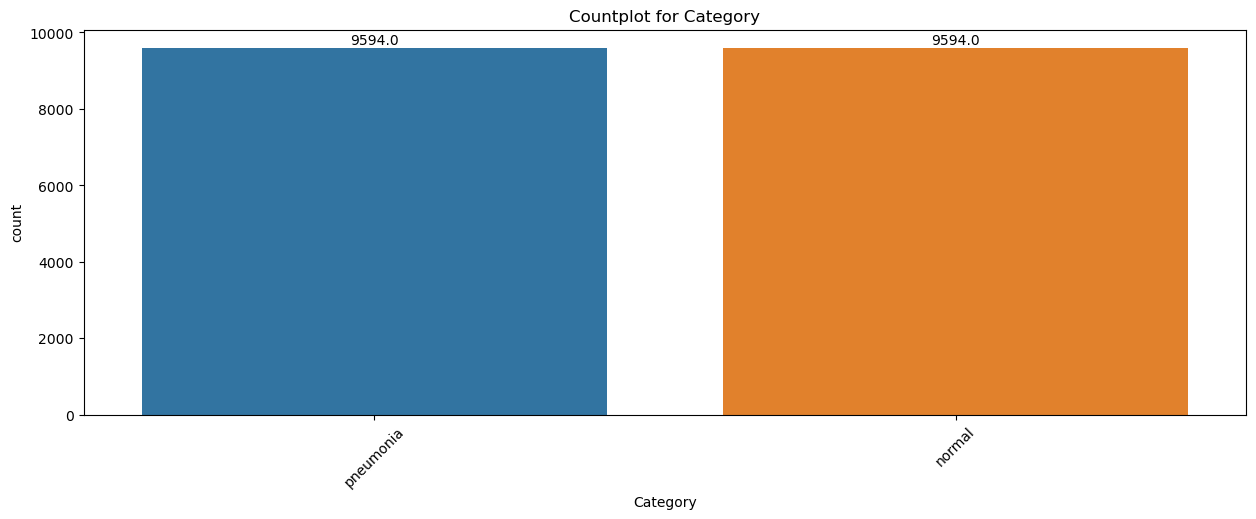

In [6]:
output_countplot(image_meta_df, 'Category', order=image_meta_df['Category'].value_counts().index)

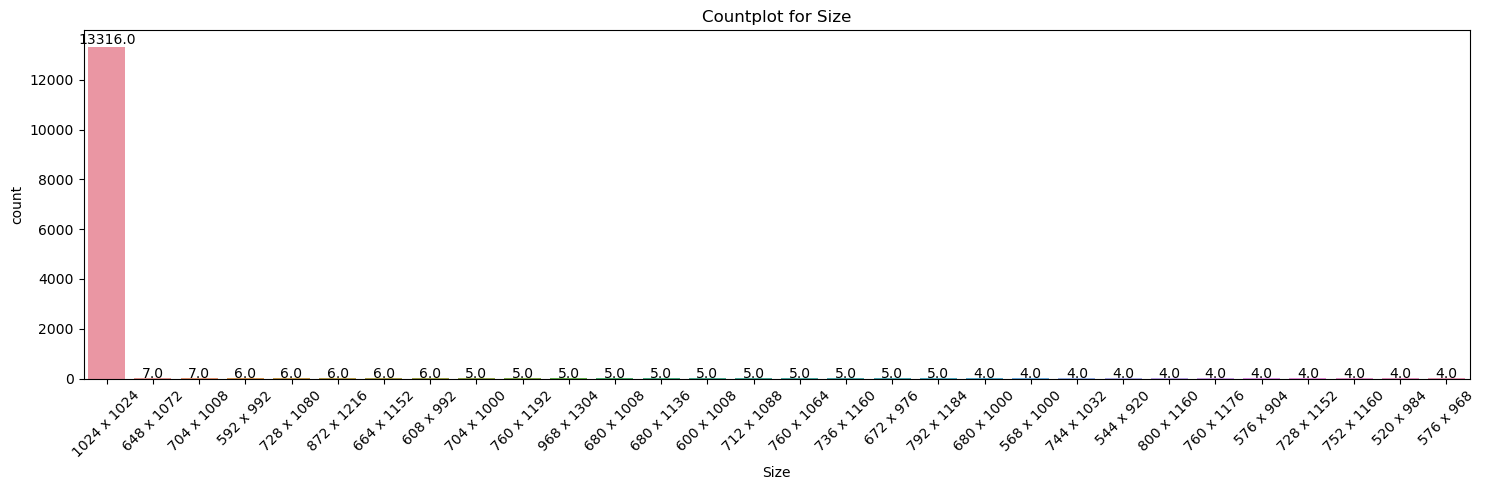

In [7]:
output_countplot(image_meta_df, 'Size', order=image_meta_df['Size'].value_counts().head(30).index)

The complete dataset is of size 1024*1024 and image count is 10000.

# Explore example category images and histograms

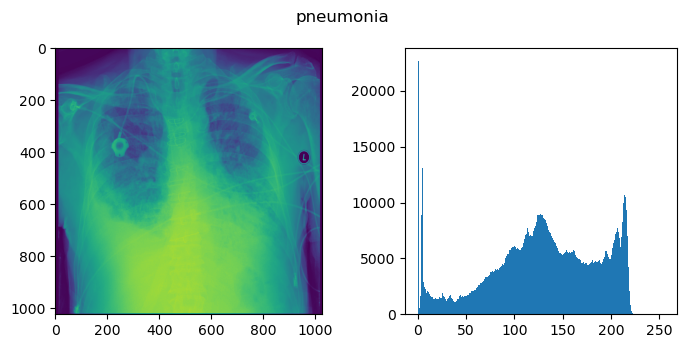

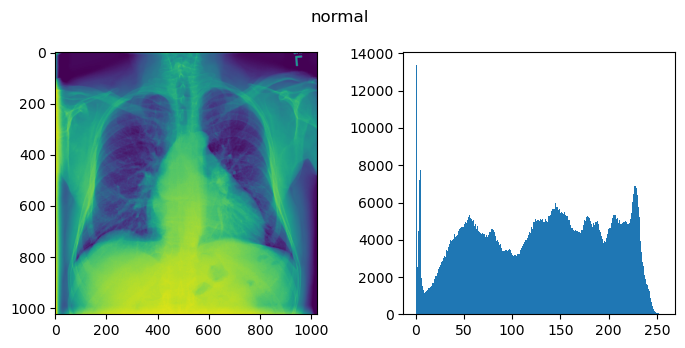

In [8]:
num_columns = 2

for i, category in enumerate(categories):

    path = os.path.join(directory, category)
    file = os.listdir(path)[0]
    filepath = os.path.join(path, file)
    img = cv2.imread(filepath, 0)

    output_image_histogram(img, category)

plt.show()

- In Pneumonia dataset, there are lot of peaks in the histogram. The biggest peak in the number of pixels is at 0 and then there are slightly bigger peaks at 120  and around 160.
- In normal dataset, the pixels are mostly between 50-200 for almost all the images.

Text(0.5, 1.0, 'normal')

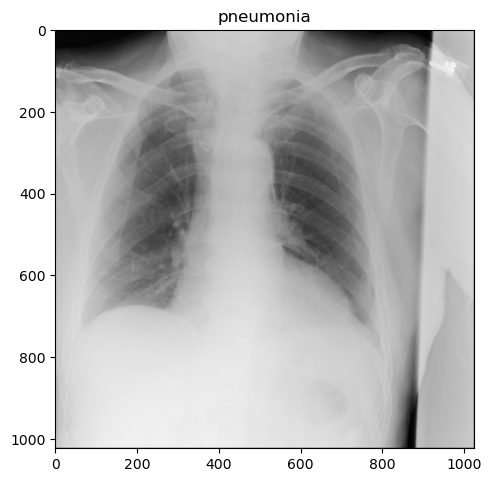

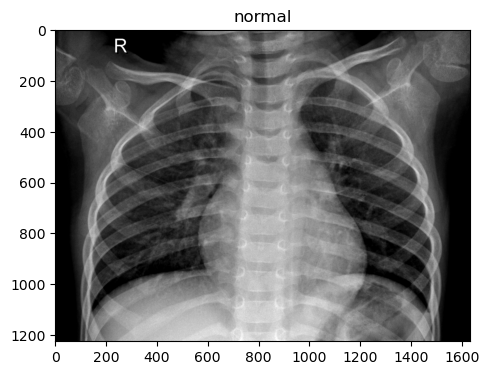

In [9]:
# Previewing the images of both the classes
plt.figure(figsize = (5,5))
plt.imshow(imgData[1][0], cmap='gray')
plt.title(labels[imgData[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(imgData[-2][0], cmap='gray')
plt.title(labels[imgData[-1][1]])

# Preprocess and normalize images and prepare dependent and independent variables

### 256x256 resize and normalization

In [10]:
X_256, Y_256 = process_normalize(directory, categories, 256)

X counts: (19188, 256, 256, 1)
y counts: (19188, 2)


# Preparing Data

## Train, test and split for the 256x256 dataset

In [11]:
X_train256, X_test256, Y_train256, Y_test256 = train_test_split(X_256, Y_256, random_state=42, stratify=Y_256)

print('X train length {}, dimensions {}'.format(len(X_train256), X_train256.shape))
print('X test length {}, dimensions {}'.format(len(X_test256), X_test256.shape))

X train length 14391, dimensions (14391, 256, 256, 1)
X test length 4797, dimensions (4797, 256, 256, 1)


In [12]:
# train_ratio = 0.75
# validation_ratio = 0.15
# test_ratio = 0.10

# # train is now 75% of the entire data set
# X_train256, X_test256, Y_train256, Y_test256 = train_test_split(X_256, Y_256, random_state=42, test_size=1 - train_ratio, stratify=Y_256)

# # test is now 10% of the initial data set
# # validation is now 15% of the initial data set
# X_val256, X_test256, Y_val256, Y_test256 = train_test_split(X_test256, Y_test256, random_state=42, test_size=test_ratio/(test_ratio + validation_ratio), stratify=Y_test256)


# print('X train length {}, dimensions {}'.format(len(X_train256), X_train256.shape))
# print('X test length {}, dimensions {}'.format(len(X_test256), X_test256.shape))
# print('X val length {}, dimensions {}'.format(len(X_val256), X_val256.shape))

### 256*256 dataset
## Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

Note: 512*512 dataset is memory intensive, hence skipped model building for the same

In [13]:
# Define the image dimensions
image_width, image_height = 256, 256
num_channels = 3
# Define the number of classes
num_classes = 2
batch_size = 10

train_generator, validation_generator = get_generators(directory, image_width, image_height, batch_size)

Found 15352 images belonging to 2 classes.
Found 3836 images belonging to 2 classes.


##  Build and fit the model

In [14]:
# Build a RESNET50V2 model
model = build_resnet50v2_model(image_width, image_height, num_channels, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,614,914
Trainable params: 1,050,114
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
# Compile the model
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='pneumonia_detection_One.RESNET50V2',
                            monitor='val_accuracy', verbose = 1,
                            save_best_only=True)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

epochs = 20

# Train the model
history_res = model.fit(train_generator,
                    epochs = epochs,
                    verbose = 1,
                    batch_size=batch_size,
                    validation_data = validation_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/20
1536/1536 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.8505
Epoch 1: val_accuracy improved from -inf to 0.68874, saving model to pneumonia_detection_One.RESNET50V2


INFO:tensorflow:Assets written to: pneumonia_detection_One.RESNET50V2\assets


INFO:tensorflow:Assets written to: pneumonia_detection_One.RESNET50V2\assets


1536/1536 [==============================] - 721s 468ms/step - loss: 0.4141 - accuracy: 0.8505 - val_loss: 0.7455 - val_accuracy: 0.6887
Epoch 2/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.8592
Epoch 2: val_accuracy did not improve from 0.68874
1536/1536 [==============================] - 773s 503ms/step - loss: 0.3868 - accuracy: 0.8592 - val_loss: 1.0687 - val_accuracy: 0.6277
Epoch 3/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.8643
Epoch 3: val_accuracy did not improve from 0.68874
1536/1536 [==============================] - 762s 496ms/step - loss: 0.3748 - accuracy: 0.8643 - val_loss: 0.7993 - val_accuracy: 0.6689
Epoch 4/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8678
Epoch 4: val_accuracy improved from 0.68874 to 0.69187, saving model to pneumonia_detection_One.RESNET50V2


INFO:tensorflow:Assets written to: pneumonia_detection_One.RESNET50V2\assets


INFO:tensorflow:Assets written to: pneumonia_detection_One.RESNET50V2\assets


1536/1536 [==============================] - 778s 506ms/step - loss: 0.3653 - accuracy: 0.8678 - val_loss: 0.7634 - val_accuracy: 0.6919
Epoch 5/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.8701
Epoch 5: val_accuracy did not improve from 0.69187
1536/1536 [==============================] - 760s 495ms/step - loss: 0.3576 - accuracy: 0.8701 - val_loss: 0.8682 - val_accuracy: 0.6546
Epoch 6/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.8733
Epoch 6: val_accuracy did not improve from 0.69187
1536/1536 [==============================] - 759s 494ms/step - loss: 0.3563 - accuracy: 0.8733 - val_loss: 0.8055 - val_accuracy: 0.6822
Epoch 7/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8698
Epoch 7: val_accuracy did not improve from 0.69187
1536/1536 [==============================] - 754s 491ms/step - loss: 0.3560 - accuracy: 0.8698 - val_loss: 0.7781 - val_accuracy: 0.6840
Epoch

INFO:tensorflow:Assets written to: pneumonia_detection_One.RESNET50V2\assets


INFO:tensorflow:Assets written to: pneumonia_detection_One.RESNET50V2\assets


1536/1536 [==============================] - 761s 495ms/step - loss: 0.3398 - accuracy: 0.8753 - val_loss: 0.7310 - val_accuracy: 0.6940
Epoch 10/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3397 - accuracy: 0.8757
Epoch 10: val_accuracy did not improve from 0.69395
1536/1536 [==============================] - 786s 512ms/step - loss: 0.3397 - accuracy: 0.8757 - val_loss: 0.7657 - val_accuracy: 0.6924
Epoch 11/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3389 - accuracy: 0.8771
Epoch 11: val_accuracy improved from 0.69395 to 0.70099, saving model to pneumonia_detection_One.RESNET50V2


INFO:tensorflow:Assets written to: pneumonia_detection_One.RESNET50V2\assets


INFO:tensorflow:Assets written to: pneumonia_detection_One.RESNET50V2\assets


1536/1536 [==============================] - 801s 522ms/step - loss: 0.3389 - accuracy: 0.8771 - val_loss: 0.7640 - val_accuracy: 0.7010
Epoch 12/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.8778
Epoch 12: val_accuracy did not improve from 0.70099
1536/1536 [==============================] - 1170s 762ms/step - loss: 0.3344 - accuracy: 0.8778 - val_loss: 0.7769 - val_accuracy: 0.7002
Epoch 13/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.8796
Epoch 13: val_accuracy did not improve from 0.70099
1536/1536 [==============================] - 1155s 752ms/step - loss: 0.3343 - accuracy: 0.8796 - val_loss: 0.7502 - val_accuracy: 0.6937
Epoch 14/20
1536/1536 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.8794
Epoch 14: val_accuracy did not improve from 0.70099
1536/1536 [==============================] - 1151s 749ms/step - loss: 0.3296 - accuracy: 0.8794 - val_loss: 0.8510 - val_accuracy: 0.6

## Evaluate the model

In [17]:
# Evaluate the model on the validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")

384/384 [==============================] - 224s 584ms/step - loss: 0.7597 - accuracy: 0.6971
Validation Loss: 0.7596527934074402, Validation Accuracy: 0.6970803141593933


In [18]:
# To load the model architecture and weights in a new session:
loaded_model = tf.keras.models.load_model('pneumonia_detection_One.RESNET50V2')

# Compile the loaded model
loaded_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
validation_loss, validation_accuracy = loaded_model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")

384/384 [==============================] - 168s 434ms/step - loss: 0.7540 - accuracy: 0.7015
Validation Loss: 0.7539682388305664, Validation Accuracy: 0.7015119791030884


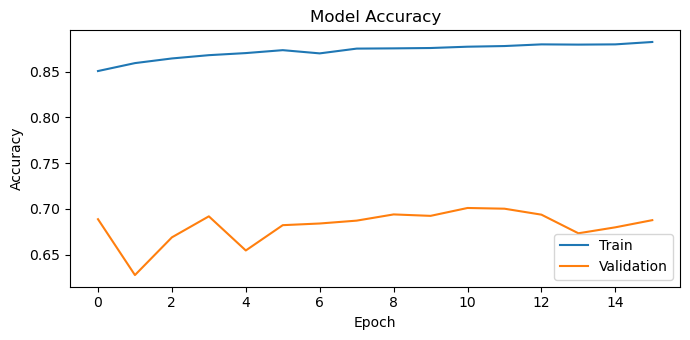

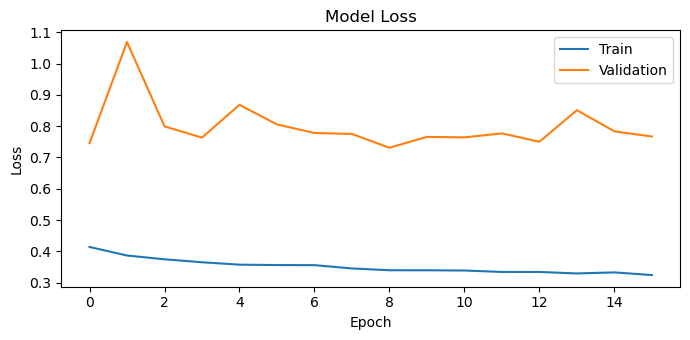

In [19]:
plt.plot(history_res.history['accuracy'], label='Train')
plt.plot(history_res.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history_res.history['loss'], label='Train')
plt.plot(history_res.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()